# Truncated SVD

In this notebook...

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import flopy
import pyemu


In [2]:
t_d = "template_history"
m_d = "master_glm_run"

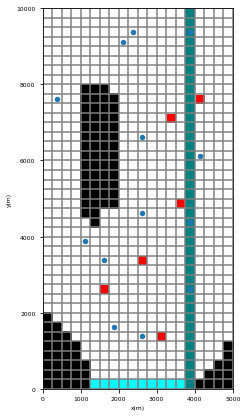

In [3]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False,forgive=False)
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
mm.plot_bc("GHB")
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

Load the control file:

In [4]:
pst = pyemu.Pst(os.path.join("master_glm","freyberg_pp.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
...,...,...,...,...,...,...,...
pp_vka0,pp_vka0,fixed,32,1,10,0.1,2.475
pp_vka1,pp_vka1,log,32,0,1,-1,0.5
pp_vka2,pp_vka2,fixed,32,1,10,0.1,2.475
welflux,welflux,log,25,0,1,-1,0.5


Load Jacobian matrix:

In [5]:
jco = pyemu.Jco.from_binary(os.path.join("master_glm","freyberg_pp.jcb"))
jco.shape

(7272, 569)

use only the non-zero-weighted obs

In [6]:
jco = jco.get(pst.nnz_obs_names,pst.adj_par_names)
jco.shape

(350, 569)

work up the components for the gauss-newton alg:

In [7]:
obscov = pyemu.Cov.from_observation_data(pst).get(pst.nnz_obs_names)
obscov.shape

(350, 350)

In [8]:
q = obscov.inv

In [9]:
jtqj = jco.T * q * jco
jtqj.shape

(569, 569)

In [10]:
jtqj.x

array([[ 6.91087205e-02,  7.44510976e-03,  6.53707337e+00, ...,
         4.41493852e-01,  5.62096148e-01,  6.85472528e-02],
       [ 7.44510976e-03,  1.15185217e-03,  7.04924853e-01, ...,
         5.90779677e-02,  7.79244861e-02,  7.15208628e-03],
       [ 6.53707337e+00,  7.04924853e-01,  6.44115204e+02, ...,
         4.07888522e+01,  5.29164280e+01, -7.45527690e+00],
       ...,
       [ 4.41493852e-01,  5.90779677e-02,  4.07888522e+01, ...,
         2.18942643e+02,  2.46356411e+02,  1.47505433e+02],
       [ 5.62096148e-01,  7.79244861e-02,  5.29164280e+01, ...,
         2.46356411e+02,  2.95797066e+02,  1.72630589e+02],
       [ 6.85472528e-02,  7.15208628e-03, -7.45527690e+00, ...,
         1.47505433e+02,  1.72630589e+02,  1.27508729e+02]])

In [11]:
type(jtqj)

pyemu.mat.mat_handler.Jco

In [12]:
c = pyemu.Cov(x=jtqj.x.copy(),names=pst.adj_par_names)
c = c.to_pearson()

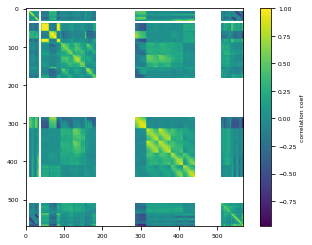

In [13]:
cb = plt.imshow(c.x)
cb = plt.colorbar(cb)
cb.set_label("correlation coef")

In [14]:
try:
    jtqj.inv
except Exception as e:
    print("frowny face: "+str(e))

frowny face: Singular matrix


### SVD to the rescue!

First let's examine the singular value matrix (`s`)

In [15]:
s = jtqj.s

Text(0, 0.5, '$log_{10}$ singular value')

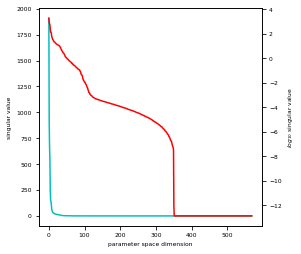

In [16]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(s.x,color="c")
axt = plt.twinx(ax)
axt.plot(np.log10(s.x),color="r")
ax.set_xlabel("parameter space dimension")
ax.set_ylabel("singular value")
axt.set_ylabel("$log_{10}$ singular value")

We see that even with 350 observations, there is significantly less information content because there is non-unique information in those 350 observations.  

In [17]:
v = jtqj.v

In [18]:
v.shape

(569, 569)

In [19]:
maxsing = 10

In [20]:
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing)

In [21]:
u1.shape,s1.shape,v1.shape

((569, 10), (10, 10), (569, 10))

reconstruct the normal matrix using the truncated SVD components

In [22]:
jtqj_t = u1 * s1 * v1.T

In [23]:
jtqj_t.shape

(569, 569)

The original normal matrix as a correlation coef matrix

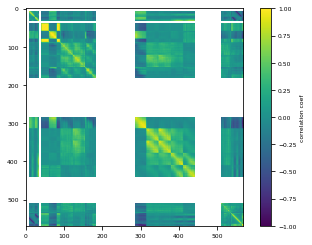

In [24]:
c = pyemu.Cov(x=jtqj.x.copy(),names=pst.adj_par_names)
c = c.to_pearson()
cb = plt.imshow(c.x,vmax=1,vmin=-1)
cb = plt.colorbar(cb)
cb.set_label("correlation coef")

The truncated normal matrix as a correlation coef matrix

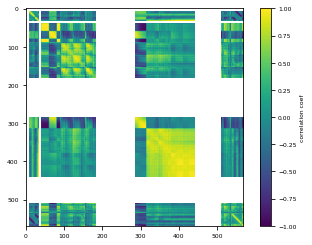

In [25]:
c = pyemu.Cov(x=jtqj_t.x.copy(),names=pst.adj_par_names)
c = c.to_pearson()
cb = plt.imshow(c.x,vmax=1,vmin=-1)
cb = plt.colorbar(cb)
cb.set_label("correlation coef")

## Exploring how truncation effects the solution process

Let's solve the gauss-netwon equation using the truncated svd inverse of the normal matrix and explore how changing the truncation level effects the solution:

In [51]:
maxsing = 350
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing,eigthresh=1e-30)

In [52]:
s1_inv = s1.inv

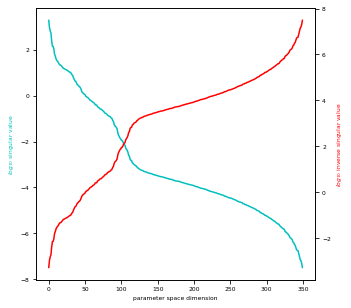

In [53]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.log10(np.diag(s1.x)),color='c')
axt = plt.twinx(ax)
axt.plot(np.log10(np.diag(s1_inv.x)),color='r')
ax.set_ylabel("$log_{10}$ singular value",color="c")
axt.set_ylabel("$log_{10}$ inverse singular value",color="r")
_ = ax.set_xlabel("parameter space dimension")

So as we use more and more singular components, we include smaller and smaller singular values in the solution (which correspond to "higher frequency" parameter and observation components - remember the image-based examples with the SVD_1 notebook).   But when we invert the singular value matrix to form a pseudo inverese, those small singluar values become very large values, essentially amplifying the high frequencey components in the solution process #sad.

Form the inverse of the normal matrix

In [29]:
jtqj_inv = v1 * s1_inv * u1.T

Get the residual vector

In [54]:
res_vec = pst.res.loc[pst.nnz_obs_names,"residual"].values
res_vec.shape

(350,)

Solve for the inverted parameter values using gauss-newton:

In [55]:
p_inv = jtqj_inv * jco.T * q * res_vec

In [56]:
p_inv.shape

(1, 569)

Let's explore how changing the truncation point effects the resulting inverted parameter values - we will only examine the magnitude of parameter changes...

In [66]:
maxsing = 50
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing,eigthresh=1e-30)
jtqj_inv = v1 * s1.inv * u1.T
p_inv = jtqj_inv * jco.T * q * res_vec
print("max abs change",np.abs(p_inv.x).max())
print("mean abs change",np.abs(p_inv.x).mean())

max abs change 2.9659631353044333
mean abs change 0.2818287606597589


So we see that if we use the full compliment of singular components (350 = nnz obs), we get crazy parameter changes.  yikes!  This implies that our inverse problem is highly sensitive to small changes in the residuals...but using 50-100 results in more reasonable changes.  

To further drive this point home, lets compare how sensitive the solution is to "expected" noise (that is, the noise we expressed through the observation weights)

Generate a single observation values plus noise realization and form a new residual vector

In [60]:
np.random.seed = 1111
oe = pyemu.ObservationEnsemble.from_gaussian_draw(pst,num_reals=1)
noisy_res_vec = oe.loc[oe.index[0],pst.nnz_obs_names] - pst.res.loc[pst.nnz_obs_names,"modelled"]
noisy_res_vec = noisy_res_vec.values

In [64]:
maxsing = 350
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing,eigthresh=1e-30)
jtqj_inv = v1 * s1.inv * u1.T
p_inv = jtqj_inv * jco.T * q * res_vec
p_inv_noisy = jtqj_inv * jco.T * q * noisy_res_vec

print("max abs change",np.abs(p_inv.x - p_inv_noisy.x).max())
print("mean abs change",np.abs(p_inv.x - p_inv_noisy.x).mean())

max abs change 2570.8385023425853
mean abs change 219.70311820515818


Again, we see that trying to use all the 350 singular components is dangerous - the resulting inverse problem is highly sensitive to noise.  But using a more convervative pseudo inverse stabilizes the problem.  #winning